Defining Quic server and its functions.



File size: 1411968:

Iteration 1:

Stream 1:
Bytes transferred: 915456
Packets transferred: 894
Average bytes per millisecond: 131.0089520420053
Average packets per millisecond: 0.1279384297285208

Stream 2:
Bytes transferred: 902144
Packets transferred: 881
Average bytes per millisecond: 131.2844527715409
Average packets per millisecond: 0.12820747340970792

Stream 3:
Bytes transferred: 958336
Packets transferred: 936
Average bytes per millisecond: 141.86063803397948
Average packets per millisecond: 0.13855428284005275

Stream 4:
Bytes transferred: 1023872
Packets transferred: 1000
Average bytes per millisecond: 154.57893754110654
Average packets per millisecond: 0.15097486555068068

Stream 5:
Bytes transferred: 1048448
Packets transferred: 1024
Average bytes per millisecond: 162.2790819231721
Average packets per millisecond: 0.1584950134764225

Stream 6:
Bytes transferred: 1081216
Packets transferred: 1056
Average bytes per millisecond: 171.97505880832486
Average packets per millise

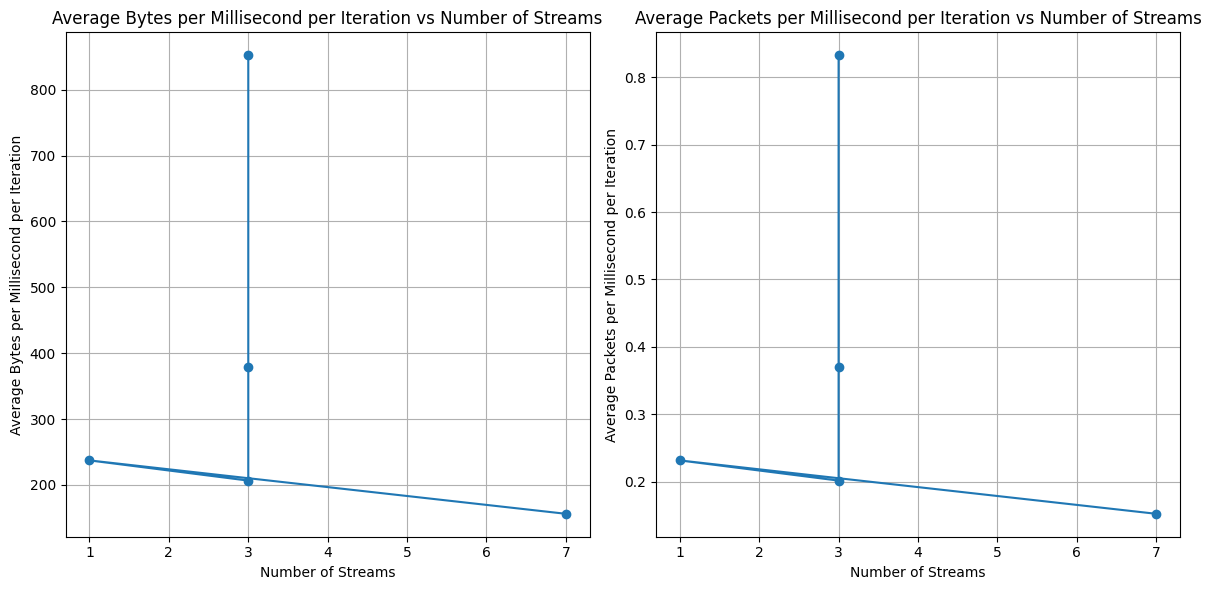

Connection closed.


In [3]:
import socket
import struct
import time
import select
import matplotlib.pyplot as plt

class QuicServer:
    local_port = 12345
    packet_size = 1024
    ready_message = b"READY"
    finished_message = b"FINISHED"

    def __init__(self):
        self.socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        self.socket.bind(('', self.local_port))
        self.stream_data = {}  # Stores data per stream per iteration
        self.start_time = {}
        self.total_bytes_received = 0
        self.total_packets_received = 0
        self.iteration = 0
        self.iteration_metrics = []  # To store average metrics for each iteration
    
    def close_connection(self):
        self.socket.close()
        print("Connection closed.")

    def process_initial_message(self):
        initial_message, sender_address = self.socket.recvfrom(4096)  # Increase buffer size to 4096 bytes
        if len(initial_message) < 8:
            raise ValueError("Initial message is too short")
        sender_ip, _ = sender_address
        num_streams, file_size = struct.unpack("!II", initial_message)
        return sender_ip, num_streams, file_size

    def update_statistics(self, received_stream_id, data):
        if self.iteration not in self.stream_data:
            self.stream_data[self.iteration] = {}
        if received_stream_id not in self.stream_data[self.iteration]:
            self.stream_data[self.iteration][received_stream_id] = {"bytes_received": 0, "packets_received": 0}
            self.start_time[(self.iteration, received_stream_id)] = time.time()
        self.stream_data[self.iteration][received_stream_id]["bytes_received"] += len(data)
        self.stream_data[self.iteration][received_stream_id]["packets_received"] += 1

        self.total_bytes_received += len(data)
        self.total_packets_received += 1

    def receive_packets(self, num_streams):
        received_data = {}
        end_packets_received = 0  # Track the number of "END" packets received for all streams
        while end_packets_received < num_streams:  # Continue until all streams have sent their "END" packets
            ready, _, _ = select.select([self.socket], [], [], 1)  # Wait for 1 second for incoming data
            if not ready:
                break  # Timeout reached, exit loop
            data, _ = self.socket.recvfrom(self.packet_size + 4)  # 4 bytes for stream_id
            received_stream_id = struct.unpack("!I", data[:4])[0]
            if data[4:] == b"END":
                end_packets_received += 1  # Increment the count of "END" packets received
                continue  # Skip processing "END" packet as it does not contain data
            if received_stream_id not in received_data:
                received_data[received_stream_id] = b""
            received_data[received_stream_id] += data[4:]
            self.update_statistics(received_stream_id, data[4:])  # Update statistics for the received stream
        return received_data

    def send_ready_message(self, sender_ip):
        server_address = (sender_ip, self.local_port + 1)
        with socket.socket(socket.AF_INET, socket.SOCK_DGRAM) as sock:
            sock.sendto(self.ready_message, server_address)
            
    def send_finished_message(self, sender_ip):
        server_address = (sender_ip, self.local_port + 1)
        with socket.socket(socket.AF_INET, socket.SOCK_DGRAM) as sock:
            sock.sendto(self.finished_message, server_address)
            
    def calculate_metrics(self):
        metrics = {}
        current_time = time.time()
        for iteration, streams in self.stream_data.items():
            total_iteration_avg_bytes_per_ms = 0
            total_iteration_avg_packets_per_ms = 0
            iteration_metrics = {}
            for stream_id, data in streams.items():
                elapsed_time_ms = (current_time - self.start_time.get((iteration, stream_id), current_time)) * 1000
                if elapsed_time_ms == 0:
                    elapsed_time_ms = 1
                avg_bytes_per_ms = data["bytes_received"] / elapsed_time_ms
                avg_packets_per_ms = data["packets_received"] / elapsed_time_ms
                iteration_metrics[stream_id] = {
                    "bytes_transferred": data["bytes_received"],
                    "packets_transferred": data["packets_received"],
                    "average_bytes_per_millisecond": avg_bytes_per_ms,
                    "average_packets_per_millisecond": avg_packets_per_ms,
                }
                total_iteration_avg_bytes_per_ms += avg_bytes_per_ms
                total_iteration_avg_packets_per_ms += avg_packets_per_ms
            metrics[iteration] = iteration_metrics
            iteration_avg_bytes_per_ms = total_iteration_avg_bytes_per_ms / len(streams) if streams else 0
            iteration_avg_packets_per_ms = total_iteration_avg_packets_per_ms / len(streams) if streams else 0
            self.iteration_metrics.append({
                "average_bytes_per_millisecond": iteration_avg_bytes_per_ms,
                "average_packets_per_millisecond": iteration_avg_packets_per_ms,
                "num_streams": len(streams)
            })
        return metrics

    def print_statistics(self, metrics, file_size):
        print(f"\nFile size: {file_size}:")
        for iteration, streams in metrics.items():
            print(f"\nIteration {iteration}:")
            for stream_id, metric in streams.items():
                print(f"\nStream {stream_id}:")
                print(f"Bytes transferred: {metric['bytes_transferred']}")
                print(f"Packets transferred: {metric['packets_transferred']}")
                print(f"Average bytes per millisecond: {metric['average_bytes_per_millisecond']}")
                print(f"Average packets per millisecond: {metric['average_packets_per_millisecond']}")
            avg_metrics = self.iteration_metrics[iteration-1]
            print(f"\nIteration {iteration} Averages:")
            print(f"Average bytes per millisecond: {avg_metrics['average_bytes_per_millisecond']}")
            print(f"Average packets per millisecond: {avg_metrics['average_packets_per_millisecond']}")
            
    def plot_metrics(self):
        avg_bytes_per_ms = [metrics["average_bytes_per_millisecond"] for metrics in self.iteration_metrics]
        avg_packets_per_ms = [metrics["average_packets_per_millisecond"] for metrics in self.iteration_metrics]
        num_streams = [metrics["num_streams"] for metrics in self.iteration_metrics]

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(num_streams, avg_bytes_per_ms, marker='o')
        plt.title('Average Bytes / Millisecond per Iteration vs Number of Streams')
        plt.xlabel('Number of Streams')
        plt.ylabel('Average Bytes / Millisecond per Iteration')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(num_streams, avg_packets_per_ms, marker='o')
        plt.title('Average Packets / Millisecond per Iteration vs Number of Streams')
        plt.xlabel('Number of Streams')
        plt.ylabel('Average Packets / Millisecond per Iteration')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def run(self):
        for _ in range(5):
            sender_ip, num_streams, file_size = self.process_initial_message()
            self.iteration += 1
            received_data = self.receive_packets(num_streams)
            if self.iteration < 5:
                self.send_ready_message(sender_ip)
            elif self.iteration == 5:
                self.send_finished_message(sender_ip)
            elif self.iteration > 5:
                print(f"Invalid iteration {self.iteration}")
        metrics = self.calculate_metrics()
        self.print_statistics(metrics, file_size)
        self.plot_metrics()
        self.close_connection()

server = QuicServer()
server.run()


Creating the server and receiving data.

The server receives an initial message that includes the amount of streams and the size of the file being transferred.
The server uses that information to appropriately receive the file over multiple streams.
For each stream, the server receives the file while updating the statistics.

Printing the statistics

Using the statistics calculated in the previous step, print the statistics for each stream and the total metrics.